In [2]:
import os
import sys
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter

from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing.label import LabelEncoder

from torch import Tensor, LongTensor
from torch.utils.data import DataLoader, Sampler
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, LambdaLR

from IPython.display import clear_output
%pylab inline

from slayer import SLayer
from provider import _data_setup
from train_functions import *

Populating the interactive namespace from numpy and matplotlib


In [3]:
!nvidia-smi

Fri Mar  1 11:03:25 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.25       Driver Version: 415.25       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX150       Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P0    N/A /  N/A |    425MiB /  2002MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
cuda_n = 0

In [5]:
class UpperDiagonalThresholdedLogTransform:
    def __init__(self, nu):
        self.b_1 = (torch.Tensor([1, 1]) / np.sqrt(2))
        self.b_2 = (torch.Tensor([-1, 1]) / np.sqrt(2))
        self.nu = nu

    def __call__(self, dgm):
        
        if dgm.ndimension() == 0:
            return dgm

        if dgm.is_cuda:
            self.b_1 = self.b_1.cuda()
            self.b_2 = self.b_2.cuda()

#         start_time = time.time()
        x = torch.mul(dgm, self.b_1.repeat(dgm.size(0), 1))
        x = torch.sum(x, 1)
        y = torch.mul(dgm, self.b_2.repeat(dgm.size(0), 1))
        y = torch.sum(y, 1)
        i = (y <= self.nu)
        y[i] = torch.log(y[i] / self.nu) + self.nu
        ret = torch.stack([x, y], 1)
#         print("upper diag threshold computation - {:.3f}s".format(time.time() - start_time))
        return ret


def pers_dgm_center_init(n_elements):
    centers = []
    while len(centers) < n_elements:
        x = np.random.rand(2)
        if x[1] > x[0]:
            centers.append(x.tolist())

    return torch.Tensor(centers)


class SLayerPHT(nn.Module):
    def __init__(self,
                 n_directions,
                 n_elements,
                 point_dim,
                 n_neighbor_directions=0,
                 center_init=None,
                 sharpness_init=None):
        super(SLayerPHT, self).__init__()

        self.n_directions = n_directions
        self.n_elements = n_elements
        self.point_dim = point_dim
        self.n_neighbor_directions = n_neighbor_directions

        self.slayers = [SLayer(n_elements, point_dim, center_init, sharpness_init)
                        for i in range(n_directions)]
        for i, l in enumerate(self.slayers):
            self.add_module('sl_{}'.format(i), l)

    def forward(self, input):
        assert len(input) == self.n_directions

        prepared_batches = None
        if all(SLayer.is_prepared_batch(b) for b in input):
            prepared_batches = input
        elif all(SLayer.is_list_of_tensors(b) for b in input):
            prepared_batches = [SLayer.prepare_batch(input_i, self.point_dim) for input_i in input]
        else:
            raise ValueError('Unrecognized input format! Expected list of Tensors or list of SLayer.prepare_batch outputs!')

        batch_size = prepared_batches[0][0].size()[0]
        assert all(prep_b[0].size()[0] == batch_size for prep_b in prepared_batches)

        output = []
        for i, sl in enumerate(self.slayers):
            i_th_output = []
            i_th_output.append(sl(prepared_batches[i]))

            for j in range(1, self.n_neighbor_directions + 1):
                i_th_output.append(sl(prepared_batches[i - j]))
                i_th_output.append(sl(prepared_batches[(i + j) % self.n_directions]))

            if self.n_directions > 0:
                i_th_output = torch.stack(i_th_output, 1)
            else:
                i_th_output = output[0]

            output.append(i_th_output)

        return output

    @property
    def is_gpu(self):
        return self.slayers[0].is_gpu

In [6]:
data_path = "data/npht_animal_32dirs.h5"

print('Loading data...')

params = {
        'data_path': None,
        'epochs': 300,
        'momentum': 0.7,
        'lr_start': 0.1,
        'lr_ep_step': 20,
        'lr_adaption': 0.5,
        'test_ratio': 0.1,
        'batch_size': 128,
        'cuda': False,
        'cuda_device_id' : cuda_n,
    }

params['data_path'] = data_path

if torch.cuda.is_available():
    params['cuda'] = True

print('Data setup...')
data_train, data_test, subscripted_views = _data_setup(params)

print("Train and test data loaded.")

Loading data...
Data setup...
Loading provider...
Create data loader...
Train and test data loaded.


In [25]:
class MyModel(torch.nn.Module):
    def __init__(self, subscripted_views):
        super(MyModel, self).__init__()
        self.subscripted_views = subscripted_views

        n_elements = 75
        n_filters = 32
        stage_2_out = 25
        n_neighbor_directions = 1

        self.transform = UpperDiagonalThresholdedLogTransform(0.1)

        self.pht_sl = SLayerPHT(len(subscripted_views),
                                n_elements,
                                2,
                                n_neighbor_directions=n_neighbor_directions,
                                center_init=self.transform(pers_dgm_center_init(n_elements)),
                                sharpness_init=torch.ones(n_elements, 2) * 4)

        self.stage_1 = []
        for i in range(len(subscripted_views)):
            seq = nn.Sequential()
            seq.add_module('conv_1', nn.Conv1d(1 + 2 * n_neighbor_directions, n_filters, 1, bias=False))
            seq.add_module('conv_2', nn.Conv1d(n_filters, 8, 1, bias=False))
            self.stage_1.append(seq)
            self.add_module('stage_1_{}'.format(i), seq)

        self.stage_2 = []
        for i in range(len(subscripted_views)):
            seq = nn.Sequential()
            seq.add_module('linear_1', nn.Linear(n_elements, stage_2_out))
            seq.add_module('batch_norm', nn.BatchNorm1d(stage_2_out))
            seq.add_module('linear_2'
                           , nn.Linear(stage_2_out, stage_2_out))
            seq.add_module('relu', nn.ReLU())
            seq.add_module('Dropout', nn.Dropout(0.4))

            self.stage_2.append(seq)
            self.add_module('stage_2_{}'.format(i), seq)

        linear_1 = nn.Sequential()
        linear_1.add_module('linear', nn.Linear(len(subscripted_views) * stage_2_out, 50))
        linear_1.add_module('batchnorm', torch.nn.BatchNorm1d(50))
        linear_1.add_module('drop_out', torch.nn.Dropout(0.3))
        self.linear_1 = linear_1

        linear_2 = nn.Sequential()
        linear_2.add_module('linear', nn.Linear(50, 20))

        self.linear_2 = linear_2


    def forward(self, batch):
        # x - dict of tensors of (b, d)-tuples of various length, keys - subscripted_views
    
        x = [batch[n] for n in self.subscripted_views]
        # x - list of lists of tensors of (b, d)-tuples of various length - len(x) == 32
        # each elem - list of tensors of (b, d)-tuples - len(x[0]) == 128
        print("x list len", len(x))
        print("one x elem (view_batch) len", len(x[0]))
        print("one view_batch elem (dgm)", x[0][0])
        
        start_time = time.time()
        # why not precompute this transform before training?
        # (it has no trainable params)
        x = [[self.transform(dgm.cpu()).cuda() for dgm in view_batch] for view_batch in x]
#         x = [list(map(lambda dgm: self.transform(dgm.cpu()).cuda(), view_batch)) for view_batch in x]
#         x = list(map(lambda view_batch: [self.transform(dgm.cpu()).cuda() for dgm in view_batch], x))
        print("transform x - {:.3f}".format(time.time() - start_time))
        
        start_time = time.time()
        x = self.pht_sl(x)
        print("apply SlayerPHT - {:.3f}".format(time.time() - start_time))

#         start_time = time.time()
        x = [l(xx) for l, xx in zip(self.stage_1, x)]
#         print("apply stage_1 layers - {:.3f}".format(time.time() - start_time))

#         start_time = time.time()
        x = [torch.squeeze(torch.max(xx, 1)[0]) for xx in x] # torch.squeeze - ?
#         print("max + squeeze each xx - {:.3f}".format(time.time() - start_time))

#         start_time = time.time()
        x = [l(xx) for l, xx in zip(self.stage_2, x)]
#         print("apply stage_2 layers x - {:.3f}".format(time.time() - start_time))
        
#         start_time = time.time()
        x = torch.cat(x, 1)
        x = self.linear_1(x)
        x = self.linear_2(x)
#         print("concat + final layers - {:.3f}".format(time.time() - start_time))
        return x

In [26]:
def train_one_epoch(model, optimizer, train_data, params, criterion, variable_created_by_model):
    
    # training
    train_loss = []
    train_preds = []
    train_targets = []
    model.train(True)
    for i, (batch_input, batch_target) in enumerate(train_data, start=1):
        
        # transform input to tensor
        batch_input, batch_target = data_typing(batch_input, batch_target, params)

        if not variable_created_by_model:
            batch_input = Variable(batch_input)
        batch_target = Variable(batch_target)
        
        start_time = time.time()
        optimizer.zero_grad()
        batch_output = model(batch_input)
        print("forward pass - {:3f}s".format(time.time() - start_time))
        loss = criterion(batch_output, batch_target)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        train_preds.extend(list(compute_labels(batch_output)))
        train_targets.extend(list(batch_target.cpu().data.numpy()))
    
    return train_loss, train_preds, train_targets

In [27]:
def train(model, optimizer, train_data, val_data, params, metric=accuracy_score, criterion=nn.CrossEntropyLoss(), variable_created_by_model=True):
    
    mean_train_loss = []
    mean_val_loss = []
    mean_train_metric = []
    mean_val_metric = []

    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.5 ** (epoch // params["lr_ep_step"]))
    
    for epoch in range(params["epochs"]):
        epoch_start_time = time.time()
        
        scheduler.step()
        print("current lr = {}".format(scheduler.get_lr()[0]))
        
        start_time = time.time()
        train_loss, train_preds, train_targets = train_one_epoch(
            model, optimizer, train_data, params, criterion, variable_created_by_model)
        print("train epoch - {:.3f}s".format(time.time() - start_time))
        start_time = time.time()
        val_loss, val_preds, val_targets = validate(
            model, val_data, params, criterion, variable_created_by_model)
        print("validate - {:3f}s".format(time.time() - start_time))

        # print the results for this epoch:
        mean_train_loss.append(np.mean(train_loss))
        mean_val_loss.append(np.mean(val_loss))
        mean_train_metric.append(metric(train_targets, train_preds))
        mean_val_metric.append(metric(val_targets, val_preds))
        
        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(mean_train_loss)
        plt.plot(mean_val_loss)
        plt.subplot(122)
        plt.plot(mean_train_metric)
        plt.plot(mean_val_metric)
        plt.gca().set_ylim([0, 1])
        plt.show()
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, params["epochs"], time.time() - epoch_start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(mean_train_loss[-1]))
        print("  validation loss: \t\t\t{:.6f}".format(mean_val_loss[-1]))
        print("  training metric: \t\t\t{:.2f}".format(mean_train_metric[-1]))
        print("  validation metric: \t\t\t{:.2f}".format(mean_val_metric[-1]))
        
#         if mean_train_loss[-1] < epsilon:
#             break

    return mean_train_loss, mean_val_loss, mean_train_metric, mean_val_metric

# ? def cross_val_trains

In [28]:
def check_scheduler(optimizer, params):
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.5 ** (epoch // params["lr_ep_step"]))
    for epoch in range(params["epochs"]):
        scheduler.step()
        print(epoch, scheduler.get_lr()[0])

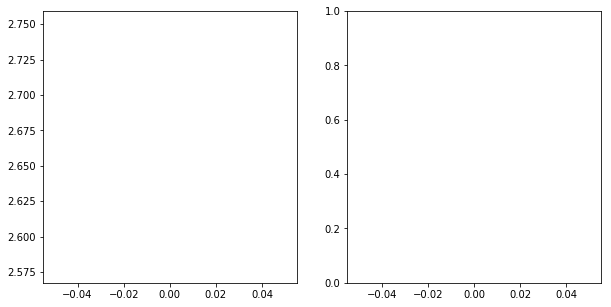

Epoch 1 of 300 took 31.959s
  training loss (in-iteration): 	2.576107
  validation loss: 			2.750532
  training metric: 			0.22
  validation metric: 			0.23
current lr = 0.1
x list len 32
one x elem (view_batch) len 128
one view_batch elem (dgm) tensor([[0.2617, 0.4187],
        [0.2735, 0.3047],
        [0.1807, 0.7840]], device='cuda:0')
transform x - 0.519
apply SlayerPHT - 0.807
forward pass - 1.345855s
x list len 32
one x elem (view_batch) len 128
one view_batch elem (dgm) tensor([[0.1439, 0.8674]], device='cuda:0')
transform x - 0.530
apply SlayerPHT - 0.714
forward pass - 1.261365s
x list len 32
one x elem (view_batch) len 128
one view_batch elem (dgm) tensor([[0.4411, 0.4775],
        [0.2065, 0.7445]], device='cuda:0')
transform x - 0.531
apply SlayerPHT - 0.777
forward pass - 1.326640s


KeyboardInterrupt: 

In [29]:
params = {
        'data_path': None,
        'epochs': 300,
        'momentum': 0.7,
        'lr_start': 0.1,
        'lr_ep_step': 20,
        'lr_adaption': 0.5,
        'test_ratio': 0.1,
        'batch_size': 128,
        'cuda': False,
        'cuda_device_id' : cuda_n,
    }

params['data_path'] = data_path

if torch.cuda.is_available():
    params['cuda'] = True
    torch.cuda.set_device(params["cuda_device_id"])


print('Create model...')
model = MyModel(subscripted_views)
if params["cuda"]:
    model.cuda(params["cuda_device_id"])

print("Create optimizer...")
optimizer = optim.SGD(model.parameters(),
                      lr=params['lr_start'],
                      momentum=params['momentum'])

# check_scheduler(optimizer, params)
mean_train_loss, mean_val_loss, mean_train_metric, mean_val_metric = train(model, optimizer, data_train, data_test, params)

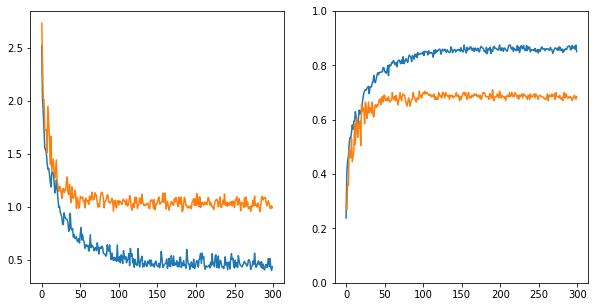

Epoch 300 of 300 took 169.888s
  training loss (in-iteration): 	0.438725
  validation loss: 			0.994084
  training metric: 			0.85
  validation metric: 			0.69


([2.5200069268544514,
  2.0212841192881266,
  1.8817838907241822,
  1.7097923517227174,
  1.5498941818873087,
  1.5501075744628907,
  1.507132601737976,
  1.4130757013956705,
  1.3556969245274861,
  1.365001924832662,
  1.3125599463780722,
  1.2390848557154337,
  1.1888000090916953,
  1.321438733736674,
  1.3301958004633585,
  1.319236167271932,
  1.2418407320976257,
  1.1327595392862955,
  1.1676104267438252,
  1.2553243438402812,
  1.1755107283592223,
  1.0775107661883037,
  0.9980735103289287,
  1.0081861019134521,
  0.9525253812472025,
  0.9320480386416118,
  0.9090413053830465,
  0.8418787956237793,
  0.8347223202387491,
  0.9457442800203959,
  0.9073262492815654,
  0.8925660610198974,
  0.8879740953445434,
  0.880461041132609,
  0.8538823008537293,
  0.7718275904655456,
  0.7871235171953838,
  0.9425887028376262,
  0.8027261575063069,
  0.7839845259984334,
  0.7989970525105794,
  0.7169420599937439,
  0.7415105779965718,
  0.7041194796562195,
  0.7049824198087057,
  0.72052294413

In [9]:
params = {
        'data_path': None,
        'epochs': 300,
        'momentum': 0.7,
        'lr_start': 0.1,
        'lr_ep_step': 20,
        'lr_adaption': 0.5,
        'test_ratio': 0.1,
        'batch_size': 128,
        'cuda': False,
        'cuda_device_id' : cuda_n,
    }

params['data_path'] = data_path

if torch.cuda.is_available():
    params['cuda'] = True
    torch.cuda.set_device(params["cuda_device_id"])


print('Create model...')
model = MyModel(subscripted_views)
if params["cuda"]:
    model.cuda(params["cuda_device_id"])

print("Create optimizer...")
optimizer = optim.SGD(model.parameters(),
                      lr=params['lr_start'],
                      momentum=params['momentum'])

# check_scheduler(optimizer, params)
mean_train_loss, mean_val_loss, mean_train_metric, mean_val_metric = train(model, optimizer, data_train, data_test, params)